# Reinforcement Learning : SmartCab from OpenAI Gym

## Problem Statement (from Gym docs):

"There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends."

## 1. Install all dependencies

In [1]:
pip install cmake

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install gym[atari]

In [3]:
!pip install scipy

## 2. Load the game environment

In [4]:
import gym

env = gym.make("Taxi-v3").env

env.render()      # renders one frame of the environment

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [5]:
env.reset() # reset the environment to a random initial state 
env.render()  # visualise our environment 


print(f"Action Space {env.action_space}")
print(f"State Space {(env.observation_space)}")

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

Action Space Discrete(6)
State Space Discrete(500)


## Encoding a random initial state for the consistency of illustration : -
 Out of all the 500 state space possible, I choose a random state and encode it and give it to the environment to render in Gym. In my case , the taxi at row 3, column 4, our passenger is at location 2, and our destination is location 3

### Note: One may start with any random state and hence feel free to play around with the state 

In [6]:
# Passenger locations:                 Destinations :
# 0: R(ed)                                0: R(ed)
# 1: G(reen)                              1: G(reen)
# 2: Y(ellow)                             2: Y(ellow)
# 3: B(lue)                               3: B(lue)
# 4: in taxi

# Encoding the state of the above 

state = env.encode(3, 4, 2, 3) # (taxi_row, taxi_column, passenger_index, destination_index)
print("State:", state)

env.s = state
env.render()       # visualise the current environment

State: 391
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



### The Reward Table
 When the Taxi environment is created, there is an initial Reward table that's also created, called 'P'. We can think of it like a (states x actions) matrix
 
###### -1 per step unless other reward is triggered.
###### +20 delivering passenger.
###### -10 executing “pickup” and “drop-off” actions illegally.

In [7]:
env.P[state]  

# Actions : There are 6 deterministic actions
# 0: move south
# 1: move north
# 2: move east
# 3: move west
# 4: pickup passenger
# 5: drop off passenger


# {action: [(probability, nextstate, reward, done)]} 

{0: [(1.0, 491, -1, False)],
 1: [(1.0, 291, -1, False)],
 2: [(1.0, 391, -1, False)],
 3: [(1.0, 371, -1, False)],
 4: [(1.0, 391, -10, False)],
 5: [(1.0, 391, -10, False)]}

## Without Reinforcement Learning
Run an infinite loop. Stop when one passenger reaches one destination (one episode), or in other words, when the received reward is 20 


In [8]:
env.s = state  # set environment to our illustration's state

# To keep track of the number of actions/loops taken for a correct drop-off 
epochs = 0
# Number of illegal pickup and drop-off actions to get a correct drop-off
penalties = 0
net_reward = 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()           # take a random action
    observation, reward, done, info = env.step(action)  # What the env returns in response to the random action taken 

    net_reward += reward
    # -10 reward for illegal “pickup” and “drop-off” actions, deemed as penalty
    if reward == -10:
        penalties += 1
    
    
    # Put each rendered frame into dictionary for animation(to be used later)
    frames.append({
        'frame': env.render(mode='ansi'),  
        'state': observation,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
   
print(f"Timesteps taken: {epochs}")
print(f"Penalties incurred: {penalties}")
print(f"Net rewards : {net_reward}")

Timesteps taken: 759
Penalties incurred: 248
Net rewards : -2970


### Conclusion
 As we are taking random actions, it is quite obvious that our agent would'nt be a good one as can be seen, it takes thousands of timesteps and lot of wrong drop-offs to deliver just one passenger correctly.

REASON : We are not learning from our mistakes, past experiences. The agent has no memory

### Visualising : -
*Note* : The state we are working with has **Y(ellow) BLUE** colored, which implies it is the **pickup point**. While, The **B(lue) is VIOLET** colored which implies it is the **drop-off destination.

In [9]:

from IPython.display import clear_output
from time import sleep

# print(frames[0]['frame'])

def visualise_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])               # display a popup window (animation)
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.05)
        
visualise_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 759
State: 475
Action: 5
Reward: 20


##  Q learning 
-  Q-learning lets the agent use the environment's rewards to learn, over time, the best action to take in a given state.

-  Q-values stored in the Q table are indicative of how good the action was, taken from that state.

- First, Q values are arbitrarily initialised , then regularly updated as the agent explores the environment and recieves different rewards for its action according to the equation:- 
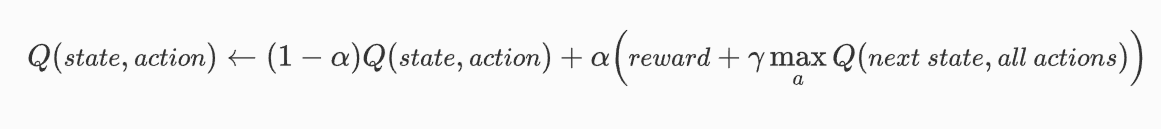

- Here, $\alpha$ - learning rate , the extent to which our Q-values are being updated in every iteration.

- $\gamma$ - discount factor, higher value implies giving much importance to long-term rewards , a value of 0 means it considers only immediate reward (Greedy)



### Creating the Q-table

In [10]:
import numpy as np

# initialize the Q-table -> (state X action) matrix
n_states = env.observation_space.n
n_actions = env.action_space.n

q_table = np.zeros([n_states, n_actions])

### Training

In [11]:
%%time  
# print the wall time for the entire cell
"""Training Algorithm"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_rewards = []
all_penalties = []

for i in range(1, 40001): #training for 40000 episodes
    state = env.reset()

    epochs, penalties, net_episode_reward, = 0, 0, 0
    done = False
    
    while not done:
        
        # Deciding whether to exploit or explore :
        if random.uniform(0, 1) < epsilon:  
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info = env.step(action) 
        
        net_episode_reward += reward 
        
        old_q_value = q_table[state, action]
        max_among_next = np.max(q_table[next_state])
        
        # updating the Q-values according to the equation
        new_value = (1 - alpha) * old_q_value + alpha * (reward + gamma * max_among_next)
        q_table[state, action] = new_value
        

        if reward == -10:
            penalties += 1

        state = next_state      # update the state
        epochs += 1

    
    
    # Plotting metrics:  Plots for penalties as a function of no of episodes trained
    all_penalties.append(penalties)
    all_rewards.append(net_episode_reward)
    all_epochs.append(epochs)

    
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 40000
Training finished.

CPU times: total: 17.4 s
Wall time: 15.4 s


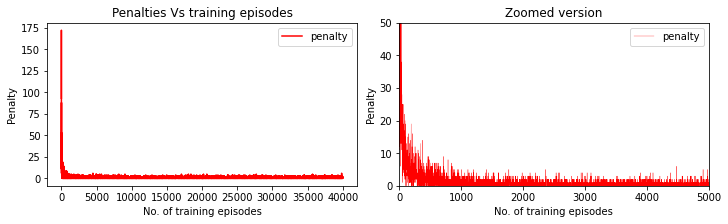

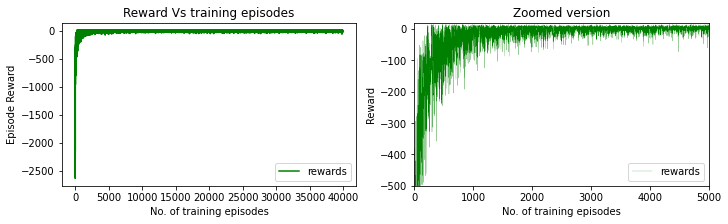

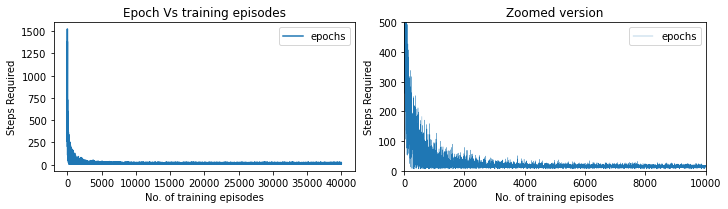

In [86]:
# Plot for different Metrics as a function of no. of episodes trained
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1, 40000, 40000) 
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 3), layout='constrained')
ax2.plot(x, all_penalties,'r', label='penalty', linewidth=0.3, markersize=10)  # Plot some data on the axes.
ax2.set_xlabel('No. of training episodes')  # Add an x-label to the axes.
ax2.set_ylabel('Penalty')  # Add a y-label to the axes.
ax2.set_ylim(0, 50)
ax2.set_xlim(0, 5000)
ax2.set_title("Zoomed version")  # Add a title to the axes.
ax2.legend();                 # Add a legend.


ax1.plot(x, all_penalties, 'r', label='penalty')  # Plot some data on the axes.
ax1.set_xlabel('No. of training episodes')  # Add an x-label to the axes.
ax1.set_ylabel('Penalty')  # Add a y-label to the axes.
ax1.set_title("Penalties Vs training episodes")  # Add a title to the axes.
ax1.legend();                 # Add a legend.


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 3), layout='constrained')
ax2.plot(x, all_rewards,'g-', label='rewards', linewidth=0.2) # Plot some data on the axes.
ax2.set_xlabel('No. of training episodes')  # Add an x-label to the axes.
ax2.set_ylabel('Reward')  # Add a y-label to the axes.
ax2.set_ylim(-500, 20)
ax2.set_xlim(0, 5000)
ax2.set_title("Zoomed version")  # Add a title to the axes.
ax2.legend();                 # Add a legend.

ax1.plot(x, all_rewards,'g', label='rewards')  # Plot some data on the axes.
ax1.set_xlabel('No. of training episodes')  # Add an x-label to the axes.
ax1.set_ylabel('Episode Reward')  # Add a y-label to the axes.
ax1.set_title("Reward Vs training episodes")  # Add a title to the axes.
ax1.legend();  


fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 2.8), layout='constrained')
ax2.plot(x, all_epochs, label='epochs', linewidth=0.3)  # Plot some data on the axes.
ax2.set_xlabel('No. of training episodes')  # Add an x-label to the axes.
ax2.set_ylabel('Steps Required')  # Add a y-label to the axes.
ax2.set_ylim(0, 500)
ax2.set_xlim(0, 10000)
ax2.set_title("Zoomed version")  # Add a title to the axes.
ax2.legend();                 # Add a legend.

ax1.plot(x, all_epochs, label='epochs')  # Plot some data on the axes.
ax1.set_xlabel('No. of training episodes')  # Add an x-label to the axes.
ax1.set_ylabel('Steps Required')  # Add a y-label to the axes.
ax1.set_title("Epoch Vs training episodes")  # Add a title to the axes.
ax1.legend();  



In [13]:
# Q-values at our illustration's state: 
state = 391
q_table[state]

array([-2.4916601 , -2.48942072, -2.49046816, -2.48942074, -9.48645214,
       -7.30431007])

### Evaluation of our model

In [19]:
"""Evaluate agent's performance after Q-learning"""
from IPython.display import clear_output

env.seed(24)
total_epochs, total_rewards,total_penalties = 0, 0, 0
episodes = 100                 
list_of_frames = []            # to visualise


for i in range(episodes):
    clear_output(wait=True)
    print(f"Episode: {i+1}")
    observation = env.reset()
    epochs, penalties, episode_reward = 0, 0, 0
    
    frames = []
    done = False
    
    while not done:
        action = np.argmax(q_table[observation])
        observation, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1

    # Put each rendered frame into dictionary for animation(to be used later)
        frames.append({
            'frame': env.render(mode='ansi'),  
            'state': observation,
            'action': action,
            'reward': reward
            }
        )
        
        epochs += 1
        episode_reward += reward

    list_of_frames.append(frames)
    total_rewards += episode_reward
    total_penalties += penalties
    total_epochs += epochs

    
print("[Evaluating Our trained Model]")
print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")
print(f"Average reward per episode: {total_rewards / episodes}")


Episode: 100
[Evaluating Our trained Model]
Results after 100 episodes:
Average timesteps per episode: 12.96
Average penalties per episode: 0.0
Average reward per episode: 8.04


### Visualising our trained-model's performance (Evaluating)

In [83]:
from IPython.display import clear_output
from time import sleep

# print(frames[0]['frame'])

passenger_no = 0

def visualise_frames(frames):
    
    global passenger_no
    passenger_no += 1
    
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(f"Dropping off Passenger number :{passenger_no}")
        print(frame['frame'])               # display a popup window (animation)
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.4)
        
    sleep(.6)
    

# visualise the first 10 episodes as it will take time for 100 episodes

for frames in list_of_frames[:10]:   # feel free to change if you want to visualise more 
    visualise_frames(frames)

Dropping off Passenger number :10
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 16
State: 0
Action: 5
Reward: 20


### No penalties implies
It performed the correct pickup/dropoff actions with 10 different passengers, without any illegal dropoff

## Exploitation Vs Exploration 
##### “Should I go for the decision that seems to be optimal, assuming that my current knowledge is reliable enough? Or should I go for a decision that seems to be sub-optimal for now, making the assumption that my knowledge could be inaccurate and that gathering new information could help me to improve it?”
There's a tradeoff between exploration (choosing a random action) and exploitation (choosing actions based on already learned Q-values). We want to prevent the action from always taking the same route, and possibly overfitting, so we'll be introducing another parameter called  "epsilon" to cater to this during training.

Instead of just selecting the best learned Q-value action, we'll sometimes favor exploring the action space further. Lower epsilon value results in episodes with more penalties (on average) which is obvious because we are exploring and making random decisions.